In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import wandb

from src.net import InstanceGCN
from src.dataset import MultiTargetDataset
from src.utils import load_from_wandb

In [3]:
api = wandb.Api()
run = api.run('brunompac/sat-gnn/rrmjzpqi')
df = run.history()
df

,gap,_runtime,infeasible,primal_curve,obj,_step,n_fixed,runtime,_timestamp,pd_integral,relative_obj,rel_primal_integral
0,2.694724e+00,53.097043,0,"{'size': 844, '_type': 'table-file', 'ncols': ...",3174.0,0,0,30.004387,1.688425e+09,6.073335e+05,1.000000,24.376927
1,7.563411e-01,83.453209,0,{'sha256': '8fbdb33dd8aa38cb2c36cdfec1faea4f65...,6605.0,1,50,30.001606,1.688425e+09,6.275064e+05,2.080970,18.543763
2,1.859479e+00,113.746338,0,{'sha256': 'ce92ece1bd45aa85e2557fa31a80a1f735...,3982.0,2,200,30.000956,1.688425e+09,6.626662e+05,1.254568,22.727228
3,2.317341e-01,144.030653,0,{'_latest_artifact_path': 'wandb-client-artifa...,9188.0,3,500,30.001620,1.688425e+09,5.939618e+05,2.894770,12.949742
4,3.718695e-02,174.300937,0,{'path': 'media/table/primal_curve_4_bc6564fda...,10568.0,4,1000,30.000666,1.688425e+09,2.869652e+05,3.329553,3.388262
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.000000e+20,2806.337117,0,{'_latest_artifact_path': 'wandb-client-artifa...,28663.0,95,0,30.003068,1.688428e+09,3.001260e+06,1.000000,30.012602
96,1.000000e+20,2836.696489,0,"{'nrows': 1, 'path': 'media/table/primal_curve...",28663.0,96,50,30.015487,1.688428e+09,3.003026e+06,1.000000,30.030264
97,1.000000e+20,2866.986819,0,"{'nrows': 2, 'path': 'media/table/primal_curve...",28560.0,97,200,30.006461,1.688428e+09,3.002085e+06,0.996407,30.021202
98,1.000000e+20,2897.393705,0,"{'_type': 'table-file', 'ncols': 2, 'nrows': 9...",27564.0,98,500,30.001054,1.688428e+09,2.380645e+06,0.961658,30.016868


,gap,_runtime,infeasible,primal_curve,obj,_step,n_fixed,runtime,_timestamp,pd_integral,relative_obj,rel_primal_integral
0,2.694724,53.097043,0,"{'size': 844, '_type': 'table-file', 'ncols': ...",3174.0,0,0,30.004387,1.688425e+09,607333.491141,1.000000,24.376927
1,0.756341,83.453209,0,{'sha256': '8fbdb33dd8aa38cb2c36cdfec1faea4f65...,6605.0,1,50,30.001606,1.688425e+09,627506.395117,2.080970,18.543763
2,1.859479,113.746338,0,{'sha256': 'ce92ece1bd45aa85e2557fa31a80a1f735...,3982.0,2,200,30.000956,1.688425e+09,662666.175853,1.254568,22.727228
3,0.231734,144.030653,0,{'_latest_artifact_path': 'wandb-client-artifa...,9188.0,3,500,30.001620,1.688425e+09,593961.765217,2.894770,12.949742
4,0.037187,174.300937,0,{'path': 'media/table/primal_curve_4_bc6564fda...,10568.0,4,1000,30.000666,1.688425e+09,286965.196321,3.329553,3.388262
...,...,...,...,...,...,...,...,...,...,...,...,...
90,1.010282,2654.756313,0,{'artifact_path': 'wandb-client-artifact://610...,6897.0,90,0,30.001127,1.688428e+09,572649.651300,1.000000,19.380866
91,3.430917,2685.035455,0,"{'_type': 'table-file', 'ncols': 2, 'nrows': 1...",3120.0,91,50,30.001832,1.688428e+09,750853.877085,0.452371,22.310545
92,3.311762,2715.317197,0,"{'size': 899, '_type': 'table-file', 'ncols': ...",3127.0,92,200,30.003587,1.688428e+09,719788.592030,0.453386,25.311055
93,0.361588,2745.604497,0,{'artifact_path': 'wandb-client-artifact://b4y...,9342.0,93,500,30.001202,1.688428e+09,552803.151386,1.354502,10.352154


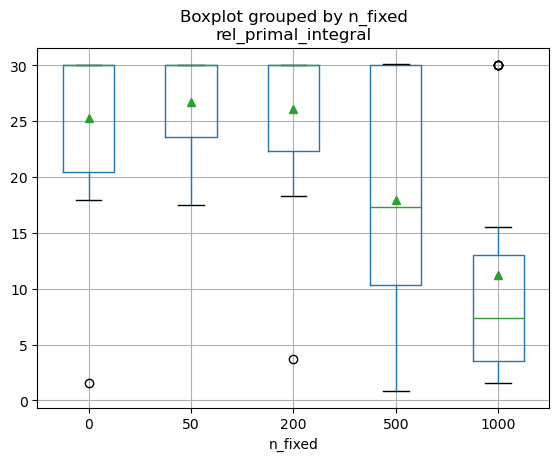

In [168]:
df.boxplot(column='rel_primal_integral', by='n_fixed', showmeans=True)
# plt.yscale('log')
plt.show()

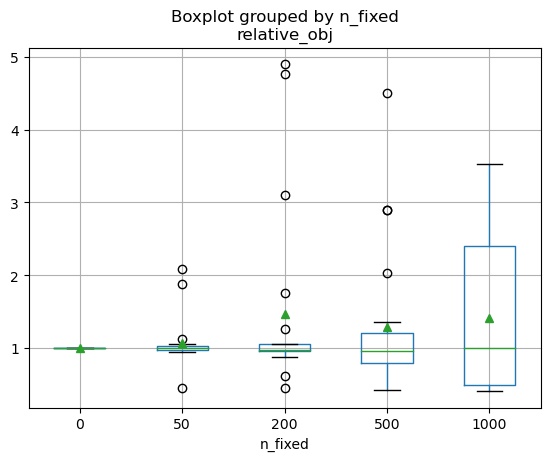

In [167]:
df.boxplot(column='relative_obj', by='n_fixed', showmeans=True)
plt.show()

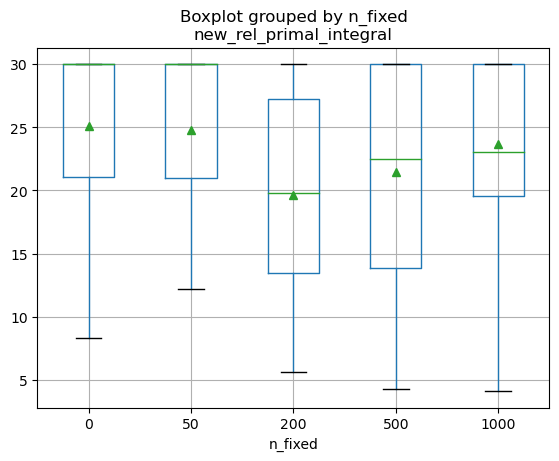

In [214]:
# import json
# import pandas as pd

# def load_table(i: int):
#     table_dir = run.logged_artifacts()[i].download()

#     table_path = f"{table_dir}/primal_curve.table.json"
#     with open(table_path) as file:
#         json_dict = json.load(file)

#     table = pd.DataFrame(json_dict["data"], columns=json_dict["columns"])
#     return table.values

# # THERE WAS A PROBLEM WITH THE LAST INSTANCE (wandb didnt upload the artifacts)
# df['primal_curve'] = df.iloc[:95]['_step'].apply(load_table)

timestep = .001
standard_range = pd.to_timedelta(np.linspace(0,30,int(30/timestep) +1), 's')
def normalize_timeseries(curve):
    c = pd.Series(curve[:,1], index=pd.to_timedelta(curve[:,0], 's'))
    c = c.reindex(standard_range, method='ffill')
    return c.values

def compute_integral(curve):
    return 30 - timestep * curve.sum()

df['normalized_primal_curve'] = df.iloc[:95]['primal_curve'].apply(normalize_timeseries)
df['new_rel_primal_integral'] = df.iloc[:95]['normalized_primal_curve'].apply(compute_integral)

df.boxplot(column='new_rel_primal_integral', by='n_fixed', showmeans=True)
plt.show()

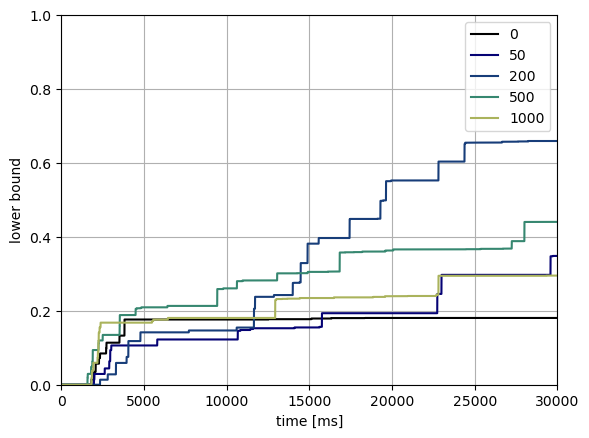

In [242]:
import matplotlib as mpl

cmap = plt.get_cmap('gist_earth')
for n in df['n_fixed'].unique():
    mean_curve = 0
    n_curves = 0
    for curve in df[df['n_fixed'] == n]['normalized_primal_curve'].iloc:
        if not curve is np.nan:
            mean_curve += curve
            n_curves += 1

    mean_curve = mean_curve / n_curves
    plt.plot(mean_curve, c=cmap(n/1500), label=n)

plt.ylabel('lower bound')
plt.xlabel('time [ms]')
plt.ylim(0,1)
plt.xlim(0,30e3)
plt.grid()
plt.legend()
plt.show()

In [18]:
model_run_id = 'lhu19g7l'
project = 'sat-gnn'

# restore model
net = InstanceGCN(readout_op=None)  # TODO: initialize net following run's config

model_run = wandb.init(project=project, id=model_run_id)
model_config = model_run.config
model_group = model_run.group
model_file = model_run.restore('model_last.pth', replace=True)
model_run.finish()

net.load_state_dict(torch.load(model_file.name))
net.eval()

run = wandb.init(project='sat-gnn', group=model_group, job_type='early-fixing-eval', config=dict(
    model_run_id=model_run_id,
    **model_config
))

In [19]:
instances_fpaths = list(Path('../data/raw/').glob('97_24*.json'))

run.config['test_instances'] = [fp.name for fp in instances_fpaths]

dataset = MultiTargetDataset(
    instances_fpaths=instances_fpaths,
    sols_dir='/home/bruno/sat-gnn/data/interim',
    split='val',
    return_model=True,
)
len(dataset)

KeyboardInterrupt: 

In [ ]:
from src.problem import ModelWithPrimalDualIntegral


def evaluate_early_fixing(model, fixed_vars: dict = None, timeout=10,
                            hide_output=True):
    model_ = ModelWithPrimalDualIntegral(sourceModel=model)
    model_.setParam('limits/time', timeout)
    model_.hideOutput(hide_output)

    if fixed_vars is not None:
        for var in model_.getVars():
            try:
                fixed_var_X = fixed_vars[var.name]
                model_.fixVar(var, fixed_var_X)
            except KeyError:
                pass

    model_.optimize()

    if model_.getStatus().lower() not in ['optimal', 'timelimit']:
        infeasible = True
        runtime = model_.getSolvingTime()
        objective = 0
        gap = -1
        primal_dual_integral = -1
    else:
        infeasible = False
        runtime = model_.getSolvingTime()
        try:
            objective = model_.getObjVal()
            gap = model_.getGap()
            primal_dual_integral = model_.get_primal_dual_integral()
        except:
            # in case the problem is not infeasible but not solution was
            # found during the time limit
            objective = 0
            gap = -1
            primal_dual_integral = -1

    return infeasible, runtime, objective, gap, primal_dual_integral

In [ ]:
# N = [0, 50, 100, 200, 500, 1000, -1]
N = [0, 50, 100, 500]
# time_budget = 10 * 60  # 10 min
time_budget = 10  # 10 s

run.config['N'] = N
run.config['ef_time_budget'] = time_budget

for graph, model in dataset:
    # TODO: device!

    vars_names = np.core.defchararray.array([v.name for v in model.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    # baseline results
    (
        baseline_infeasible,
        baseline_runtime,
        baseline_obj,
        baseline_gap,
        baseline_pd_integral
    ) = evaluate_early_fixing(model, None, time_budget)

    if baseline_infeasible:
        print('INFEASIBLE PROBLEM')
        print(model)
        continue

    with torch.set_grad_enabled(False):
        x_hat = net.get_candidate(graph).flatten().cpu()
        x_hat = x_hat[:len(vars_names)]  # drop zetas

    most_certain_idx  = (x_hat - 0.5).abs().sort(descending=True).indices

    for i in range(len(N)):
        n = N[i] if N[i] >= 0 else len(x_hat)

        if n == 0:
            result = {
                'infeasibles': 0,
                'runtimes': baseline_runtime,
                'objs': baseline_obj,
                'gaps': baseline_gap,
                'pd_integrals': baseline_pd_integral,
            }
            run.log(
                dict(n_fixed=n, **result)
            )
            continue

        fixed_x_hat = (x_hat[most_certain_idx[:n]] > .5).to(x_hat)
        fixed_vars_names = vars_names[most_certain_idx[:n]]
        fixed_vars = dict(zip(fixed_vars_names, fixed_x_hat))

        (
            infeasible, runtime, obj, gap, pd_integral
        ) = evaluate_early_fixing(model, fixed_vars, time_budget)

        if infeasible:
            result = {
                'runtimes': baseline_runtime + runtime,
                'objs': baseline_obj,
                'gaps': baseline_gap,
                'pd_integrals': baseline_pd_integral,
            }
        else:
            result = {
                'runtimes': runtime,
                'objs': obj,
                'gaps': gap,
                'pd_integrals': pd_integral,
            }
        result['infeasibles'] = int(infeasible)

        run.log(
            dict(n_fixed=n, **result)
        )


In [ ]:
wandb.finish()

gaps,▁▁██████▁▁▁███████▁▁██▁▁██████▁▁▁▁██▁▁██
infeasibles,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_fixed,▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁█
objs,▂▁██████▂▂▂███████▂▂██▁▁██████▂▂▁▃██▁▁██
pd_integrals,▆▆▁▁▁▁▁▁▆▅▇▁▁▁▁▁▁▁▇▆▁▁█▇▁▁▁▁▁▁▇▇█▄▁▁██▁▁
runtimes,▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▆▁▂▁▂▁▃▁▄▂█▁▂▃▂▂▄▃▅▁▁▂▁▂▁
gaps,1e+20
infeasibles,0
n_fixed,500
objs,27576.0
pd_integrals,100147.24
